In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [3]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_8112\3091154780.py:1: SyntaxWarning: invalid escape sequence '\y'
  ex_img = cv2.imread('Training_data\yes\Train_Tumor (1).jpg')


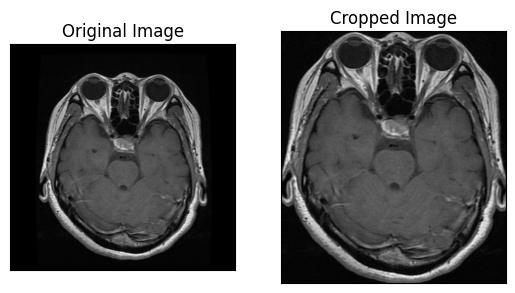

In [4]:
ex_img = cv2.imread('Training_data\yes\Train_Tumor (1).jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)
        
    # Shuffle the data
    X, y = shuffle(X, y)
        
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    return X, y

In [6]:
augmented_path = 'Training_data/'

augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2025
X shape is: (2025, 240, 240, 3)
y shape is: (2025, 1)


In [7]:
def plot_sample_images(X, y, n=50):
   
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

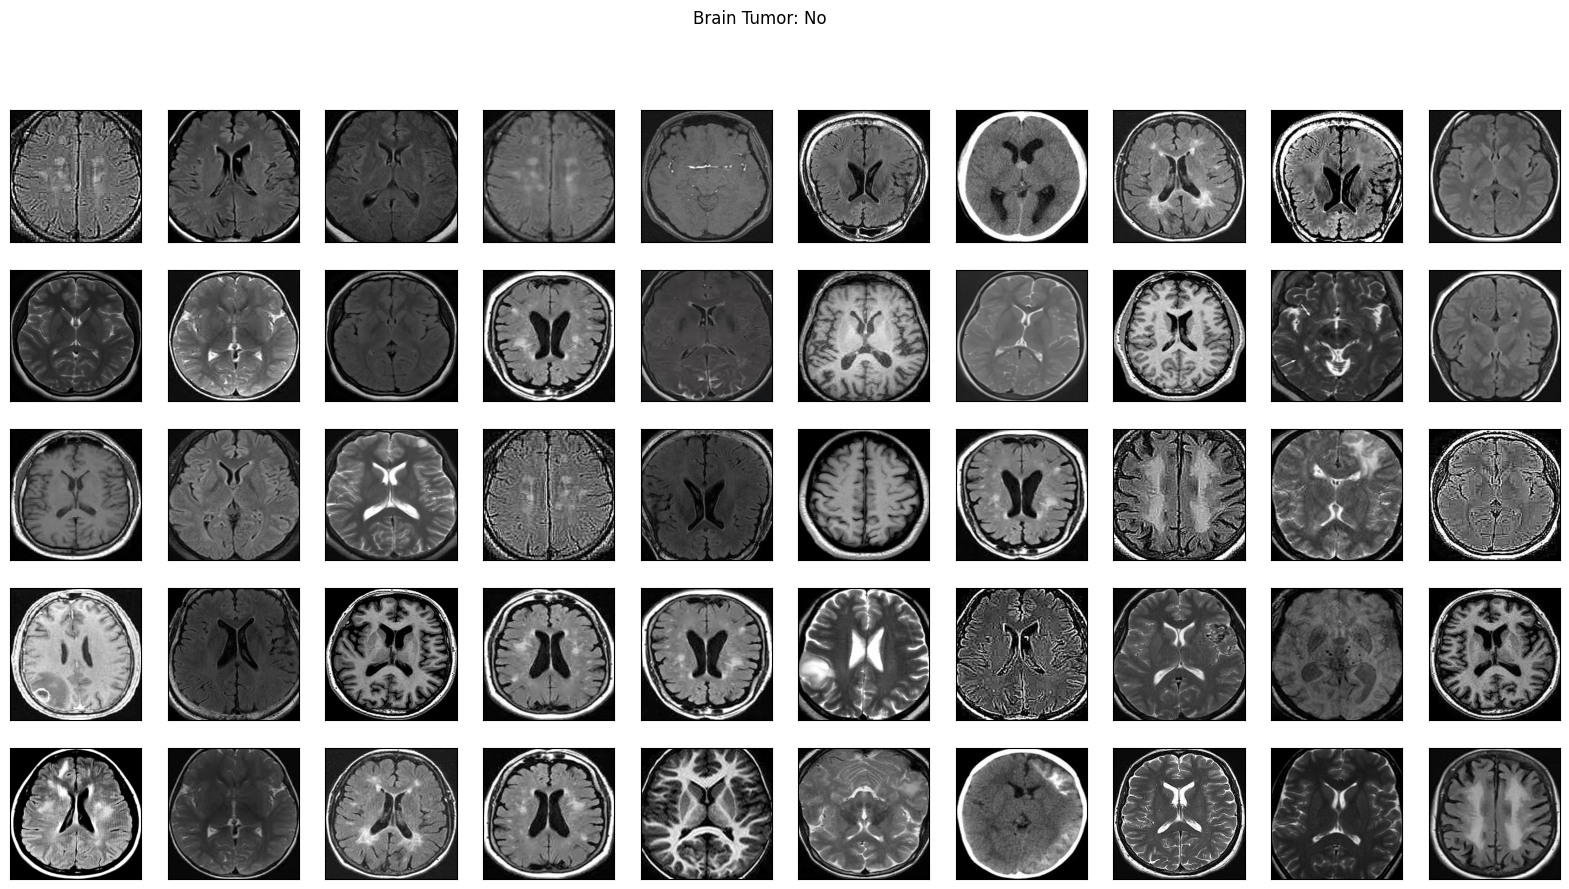

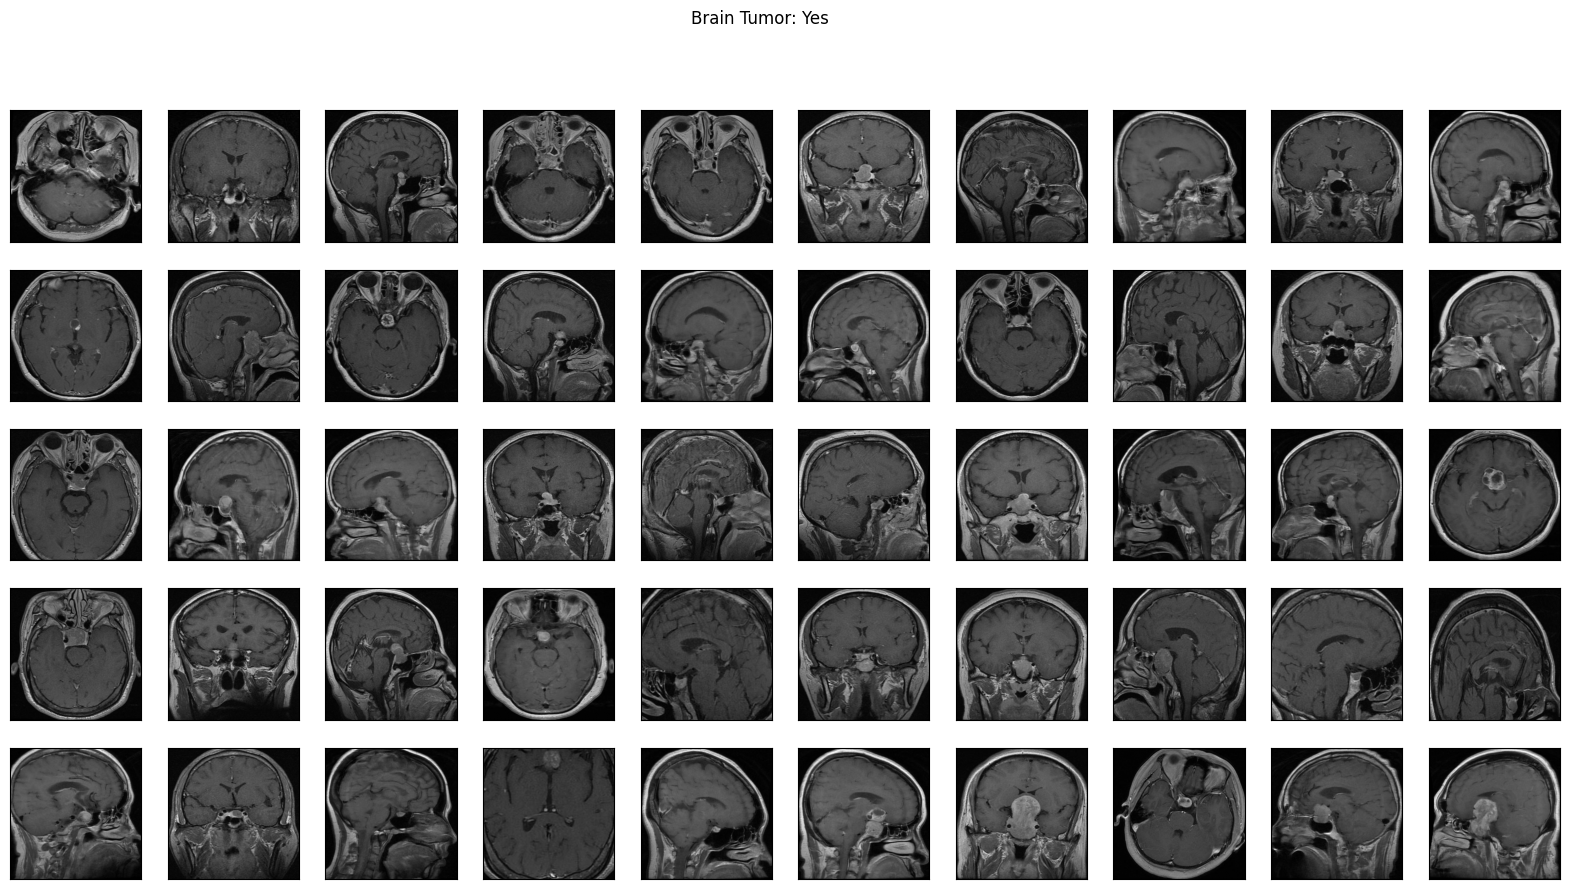

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1417
number of development examples = 304
number of test examples = 304
X_train shape: (1417, 240, 240, 3)
Y_train shape: (1417, 1)
X_val (dev) shape: (304, 240, 240, 3)
Y_val (dev) shape: (304, 1)
X_test shape: (304, 240, 240, 3)
Y_test shape: (304, 1)


In [13]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [15]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [21]:
# Define the file path for saving the model
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras"

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    filepath="models/{}".format(filepath), 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [23]:
# Define the file path for saving the model
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    filepath="models/{}".format(filepath), 
    monitor='val_accuracy',  # Use 'val_accuracy' instead of 'val_acc'
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Training the model
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=1, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7223 - loss: 1.0049
Epoch 1: val_accuracy improved from -inf to 0.50329, saving model to models/cnn-parameters-improvement-01-0.50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7248 - loss: 0.9938 - val_accuracy: 0.5033 - val_loss: 1.0537
Elapsed time: 0:1:16.2


In [28]:
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=3, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9972 - loss: 0.0123
Epoch 1: val_accuracy improved from 0.98684 to 0.99013, saving model to models/cnn-parameters-improvement-01-0.99.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9972 - loss: 0.0124 - val_accuracy: 0.9901 - val_loss: 0.0387
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9961 - loss: 0.0223
Epoch 2: val_accuracy did not improve from 0.99013
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9962 - loss: 0.0222 - val_accuracy: 0.9836 - val_loss: 0.0688
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9996 - loss: 0.0074
Epoch 3: val_accuracy improved from 0.99013 to 0.99342, saving model to models/cnn-parameters-improvement-03-0.99.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9996 - loss: 0.0074 - val_accuracy: 0.9934 - val_loss: 0.0575
Elapsed time: 0:3:18.4


In [29]:
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=3, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - loss: 0.0075
Epoch 1: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 0.9868 - val_loss: 0.0646
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9998 - loss: 0.0063
Epoch 2: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9998 - loss: 0.0063 - val_accuracy: 0.9868 - val_loss: 0.0704
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0035
Epoch 3: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9836 - val_loss: 0.0773
Elapsed time: 0:3:18.1


In [30]:
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=3, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0071
Epoch 1: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9934 - val_loss: 0.0473
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9996 - loss: 0.0045
Epoch 2: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9996 - loss: 0.0046 - val_accuracy: 0.9868 - val_loss: 0.0637
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0045
Epoch 3: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9868 - val_loss: 0.0657
Elapsed time: 0:3:18.8


In [31]:
start_time = time.time()

model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=5, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9999 - loss: 0.0040
Epoch 1: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9999 - loss: 0.0040 - val_accuracy: 0.9934 - val_loss: 0.0403
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9980 - loss: 0.0093
Epoch 2: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9980 - loss: 0.0093 - val_accuracy: 0.9934 - val_loss: 0.0498
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0043
Epoch 3: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9836 - val_loss: 0.0801
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0033
Epoch 4: val_accuracy did not improve from 0.99342
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9836 - val_loss: 0.0697
Epoch 5/

In [24]:
history = model.history.history

In [25]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [26]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

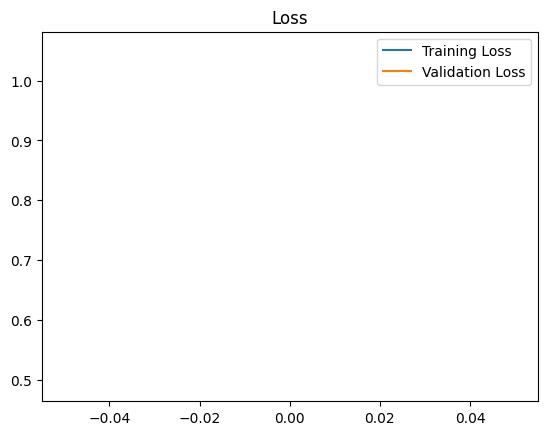

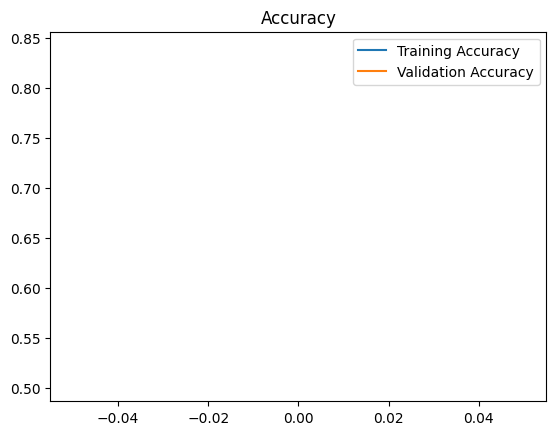

In [27]:
plot_metrics(history) 

In [28]:
best_model = load_model(filepath='models/cnn-parameters-improvement-03-0.99.keras')

In [29]:
best_model.metrics_names

['loss', 'compile_metrics']

In [30]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 1.0000 - loss: 0.0092


In [31]:
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9908 - loss: 0.0245


In [32]:
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.0421416275203228
Validation Accuracy: 0.9934210777282715


In [33]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.008131110109388828
Test Accuracy = 1.0


In [34]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step


In [35]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 1.0


In [36]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


In [37]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.993421052631579


In [38]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [39]:
# the whole data
data_percentage(y)

Number of examples: 2025
Percentage of positive examples: 50.22222222222222%, number of pos examples: 1017
Percentage of negative examples: 49.77777777777778%, number of neg examples: 1008


In [40]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1417
Percentage of positive examples: 49.400141143260406%, number of pos examples: 700
Percentage of negative examples: 50.599858856739594%, number of neg examples: 717
Validation Data:
Number of examples: 304
Percentage of positive examples: 49.671052631578945%, number of pos examples: 151
Percentage of negative examples: 50.328947368421055%, number of neg examples: 153
Testing Data:
Number of examples: 304
Percentage of positive examples: 54.60526315789474%, number of pos examples: 166
Percentage of negative examples: 45.39473684210526%, number of neg examples: 138


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.0001111]]


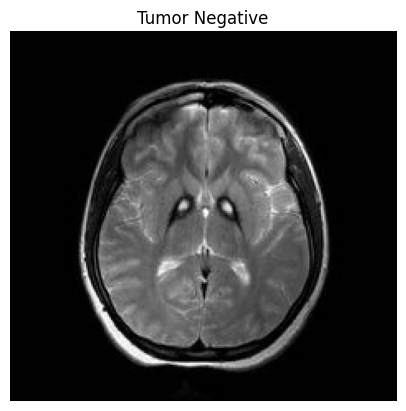

Prediction: Tumor Negative


In [44]:
image_path = 'Training_data/no/Train_No-tumor (99).jpg'

# Read the image
image = cv2.imread(image_path)

# Crop the brain contour (if applicable)
image = crop_brain_contour(image, plot=False)

# Resize the image to the required input size for the model (240x240)
image = cv2.resize(image, (240, 240))

# Normalize the image
image = image / 255.0

# Expand dimensions to match the model's input shape (1, 240, 240, 3)
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = best_model.predict(image)

print(prediction)
# Interpret the prediction
if prediction > 0.5:
    result = "Tumor Positive"
else:
    result = "Tumor Negative"

# Convert the image to RGB for correct display
img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Display the image with the result
plt.imshow(img_rgb)
plt.title(result)
plt.axis('off')
plt.show()

print(f"Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.99919164]]


<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_8112\2508668631.py:1: SyntaxWarning: invalid escape sequence '\y'
  image_path = 'Training_data\yes\Train_Tumor (99).jpg'


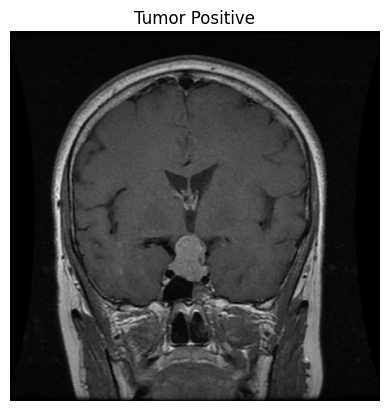

Prediction: Tumor Positive


In [47]:
image_path = 'Training_data\yes\Train_Tumor (99).jpg'

# Read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Image not found at {image_path}")
else:
    # Crop the brain contour (if applicable)
    image = crop_brain_contour(image, plot=False)

    # Resize the image to the required input size for the model (240x240)
    image = cv2.resize(image, (240, 240))

    # Normalize the image
    image = image / 255.0

    # Expand dimensions to match the model's input shape (1, 240, 240, 3)
    image = np.expand_dims(image, axis=0)

    # Make the prediction
    prediction = best_model.predict(image)
    print(prediction)

    # Interpret the prediction
    if prediction > 0.5:
        result = "Tumor Positive"
    else:
        result = "Tumor Negative"

    # Convert the image to RGB for correct display
    img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Display the image with the result
    plt.imshow(img_rgb)
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {result}")


In [50]:
from flask import Flask, request, render_template, redirect, url_for
import numpy as np
import cv2
from tensorflow.keras.models import load_model
#from crop_brain_contour import crop_brain_contour  # Assuming you already have this function

app = Flask(__name__)

# Load the pre-trained model
model = load_model('models/cnn-parameters-improvement-03-0.99.keras')

def prepare_image(image_path):
    # Read the image, crop, resize, normalize, and expand dimensions
    image = cv2.imread(image_path)
    image = crop_brain_contour(image, plot=False)
    image = cv2.resize(image, (240, 240))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

@app.route('/')
def index():
    return render_template('./index.html')



@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return redirect(request.url)

    file = request.files['image']
    if file.filename == '':
        return redirect(request.url)

    # Save the uploaded file temporarily in the static directory
    image_path = f'static/uploaded_image.jpg'
    file.save(image_path)

    # Prepare the image and make the prediction
    image = prepare_image(image_path)
    prediction = model.predict(image)

    # Interpret the result
    result = "Tumor Positive" if prediction > 0.5 else "Tumor Negative"
    prediction_value = float(prediction[0][0])  # Extract the prediction value

    # Pass the result, prediction value, and image path to the template
    return render_template(
        'result.html', 
        result=result, 
        prediction_value=prediction_value, 
        image_path='uploaded_image.jpg'
    )


if __name__ == '__main__':
    app.run(debug=False)  # Set debug=False


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


127.0.0.1 - - [28/Dec/2024 03:35:48] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [28/Dec/2024 03:35:48] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Dec/2024 03:35:48] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [28/Dec/2024 03:36:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Dec/2024 03:36:18] "GET /static/styles.css HTTP/1.1" 304 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [28/Dec/2024 03:36:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [28/Dec/2024 03:36:25] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Dec/2024 03:36:25] "GET /static/uploaded_image.jpg HTTP/1.1" 200 -
